In [2]:
%cd /nfsd/sysbiobig/bazzaccoen/tangramlit_dev

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev


In [3]:
import tangramlit as tgl

/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/myvenv/lib64/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text 

In [4]:
import scanpy as sc
import numpy as np 
import torch
import yaml

In [5]:
# Set data path
data_path = "/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/data"

# Training config

In [6]:
# Read config yaml
with open("train_config.yaml", "r") as f:
        config = yaml.safe_load(f)

config  # contains rng seed!

{'cluster_label': 'Allen.class_label',
 'lambda_count': 0.001,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': False,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': 'None'}

# Dataset 0

## Data loading

In [7]:
adata_sc = sc.read_h5ad(data_path + "/counts100k_norm_wo_raw_light.h5ad")
adata_sc

AnnData object with n_obs × n_vars = 100000 × 31053
    obs: 'nUMI', 'nGene', 'dataset', 'QC', 'cluster', 'Allen.cluster_id', 'Allen.cluster_label', 'Allen.cluster_color', 'Allen.class_label', 'Allen.subclass_label', 'comb.QC'
    var: 'gene_ids', 'feature_types'

In [8]:
adata_st = sc.read_h5ad(data_path + "/slice200_norm_with_spatial.h5ad")
adata_st

AnnData object with n_obs × n_vars = 2155 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'is_sequential', 'is_combinatorial'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

## Train/Val genes split

In [9]:
# Get shared genes (case-insensitive)
sc_genes = {gene.lower(): gene for gene in adata_sc.var_names}
st_genes = {gene.lower(): gene for gene in adata_st.var_names}

# Find intersection of lowercase gene names
shared_genes_set = set(sc_genes.keys()) & set(st_genes.keys())
shared_genes = [gene_lower for gene_lower in shared_genes_set]

# Shuffle the shared genes
shared_genes = np.array(shared_genes)
np.random.shuffle(shared_genes)

# Split into train and validation
train_ratio = 0.8
n_train = int(len(shared_genes) * train_ratio)
train_genes = shared_genes[:n_train]
val_genes = shared_genes[n_train:]

print(len(train_genes), "training genes: ", train_genes[0:10], "...")
print(len(val_genes), "validation genes: ", val_genes[0:10], "...")

202 training genes:  ['fezf2' 'tbc1d4' 'cspg4' 'tox' 'shisa9' 'crhr2' 'slc17a6' 'wipf3' 'fst'
 'prokr2'] ...
51 validation genes:  ['col24a1' 'bdnf' 'vtn' 'ltf' 'prss12' 'rgs5' 'c1ql3' 'col23a1' 'nxph2'
 'adamts2'] ...


## Model training

In [9]:
ad_map, mapper, mapper_data = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.377   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 51 genes
S matrix shape: torch.Size([80799, 51])
G matrix shape: torch.Size([2133, 51])

Validation 0: {'val_score': 0.3468501567840576, 'val_sparsity-weighted_score': 0.00819569081068039, 'val_AUC': 0.5183187127113342, 'val_entropy': 0.9348850846290588}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 201 genes
S matrix shape: torch.Size([80799, 201])
G matrix shape: torch.Size([2133, 201])


Trainig:   0%|          | 1/1000 [00:24<6:47:20, 24.47s/it]

Epoch 0: {'loss': -3.2707719802856445, 'main_loss': 0.35520753264427185, 'vg_reg': 0.36288484930992126, 'kl_reg': 1.1205906425004741e-08, 'entropy_reg': -0.0005790185532532632, 'l1_term': 1.375221785337999e-07, 'l2_term': 1.7236176375057255e-10, 'sparsity_term': 0.4512714445590973, 'neighborhood_term': 0.5123985409736633, 'getis_ord_term': 0.5982781052589417, 'moran_term': -0.0010149889858439565, 'geary_term': 0.992325484752655, 'ct_island_term': 0.0}


Trainig:   5%|▍         | 49/1000 [19:45<6:24:38, 24.27s/it]Metric val_score improved. New best score: 0.497
Epoch 49, global step 50: 'val_score' reached 0.49685 (best 0.49685), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=49-val_score=0.497.ckpt' as top 3



Validation 49: {'val_score': 0.49684712290763855, 'val_sparsity-weighted_score': 0.011012475937604904, 'val_AUC': 0.6648120880126953, 'val_entropy': 0.7710425853729248}


Trainig:  10%|▉         | 99/1000 [40:04<6:04:54, 24.30s/it]Metric val_score improved by 0.052 >= min_delta = 0.001. New best score: 0.549
Epoch 99, global step 100: 'val_score' reached 0.54874 (best 0.54874), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=99-val_score=0.549.ckpt' as top 3



Validation 99: {'val_score': 0.5487428307533264, 'val_sparsity-weighted_score': 0.012285479344427586, 'val_AUC': 0.7103155851364136, 'val_entropy': 0.2620041072368622}


Trainig:  10%|█         | 101/1000 [40:59<6:25:42, 25.74s/it]

Epoch 100: {'loss': -5.644835948944092, 'main_loss': 0.8031752705574036, 'vg_reg': 0.5776690244674683, 'kl_reg': 8.049202006077394e-05, 'entropy_reg': -0.00016227156447712332, 'l1_term': 1.6188411677831027e-07, 'l2_term': 2.636485196827465e-10, 'sparsity_term': 0.8240855932235718, 'neighborhood_term': 0.837359607219696, 'getis_ord_term': 0.8618824481964111, 'moran_term': 0.7427829504013062, 'geary_term': 0.9984946846961975, 'ct_island_term': 0.0003708240110427141, 'lr': 0.10000000149011612, 'val_score': 0.5487428307533264, 'val_sparsity-weighted_score': 0.012285479344427586, 'val_AUC': 0.7103155851364136, 'val_entropy': 0.2620041072368622}


Trainig:  15%|█▍        | 149/1000 [1:00:22<5:43:43, 24.23s/it]Metric val_score improved by 0.004 >= min_delta = 0.001. New best score: 0.552
Epoch 149, global step 150: 'val_score' reached 0.55229 (best 0.55229), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=149-val_score=0.552.ckpt' as top 3



Validation 149: {'val_score': 0.5522865056991577, 'val_sparsity-weighted_score': 0.01239168643951416, 'val_AUC': 0.7133074998855591, 'val_entropy': 0.13911454379558563}


Trainig:  20%|█▉        | 199/1000 [1:20:41<5:23:25, 24.23s/it]Metric val_score improved by 0.001 >= min_delta = 0.001. New best score: 0.553
Epoch 199, global step 200: 'val_score' reached 0.55329 (best 0.55329), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=199-val_score=0.553.ckpt' as top 3



Validation 199: {'val_score': 0.5532898902893066, 'val_sparsity-weighted_score': 0.01242437306791544, 'val_AUC': 0.7138212323188782, 'val_entropy': 0.10850968211889267}


Trainig:  20%|██        | 201/1000 [1:21:36<5:41:36, 25.65s/it]

Epoch 200: {'loss': -5.78775691986084, 'main_loss': 0.8283193111419678, 'vg_reg': 0.608065128326416, 'kl_reg': 0.00010575454507488757, 'entropy_reg': -6.720517558278516e-05, 'l1_term': 1.6346346853879368e-07, 'l2_term': 2.7305738226068854e-10, 'sparsity_term': 0.8468728065490723, 'neighborhood_term': 0.8588378429412842, 'getis_ord_term': 0.8810730576515198, 'moran_term': 0.7662266492843628, 'geary_term': 0.9986286163330078, 'ct_island_term': 9.33051633182913e-05, 'lr': 0.10000000149011612, 'val_score': 0.5532898902893066, 'val_sparsity-weighted_score': 0.01242437306791544, 'val_AUC': 0.7138212323188782, 'val_entropy': 0.10850968211889267}


Trainig:  25%|██▍       | 249/1000 [1:41:12<5:05:39, 24.42s/it]Monitored metric val_score did not improve in the last 1 records. Best score: 0.553. Signaling Trainer to stop.
Epoch 249, global step 250: 'val_score' reached 0.55391 (best 0.55391), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=249-val_score=0.554.ckpt' as top 3



Validation 249: {'val_score': 0.5539061427116394, 'val_sparsity-weighted_score': 0.012447159737348557, 'val_AUC': 0.7150275111198425, 'val_entropy': 0.09383578598499298}


Trainig:  25%|██▌       | 250/1000 [1:41:43<5:05:10, 24.41s/it]


## Loss Landscape

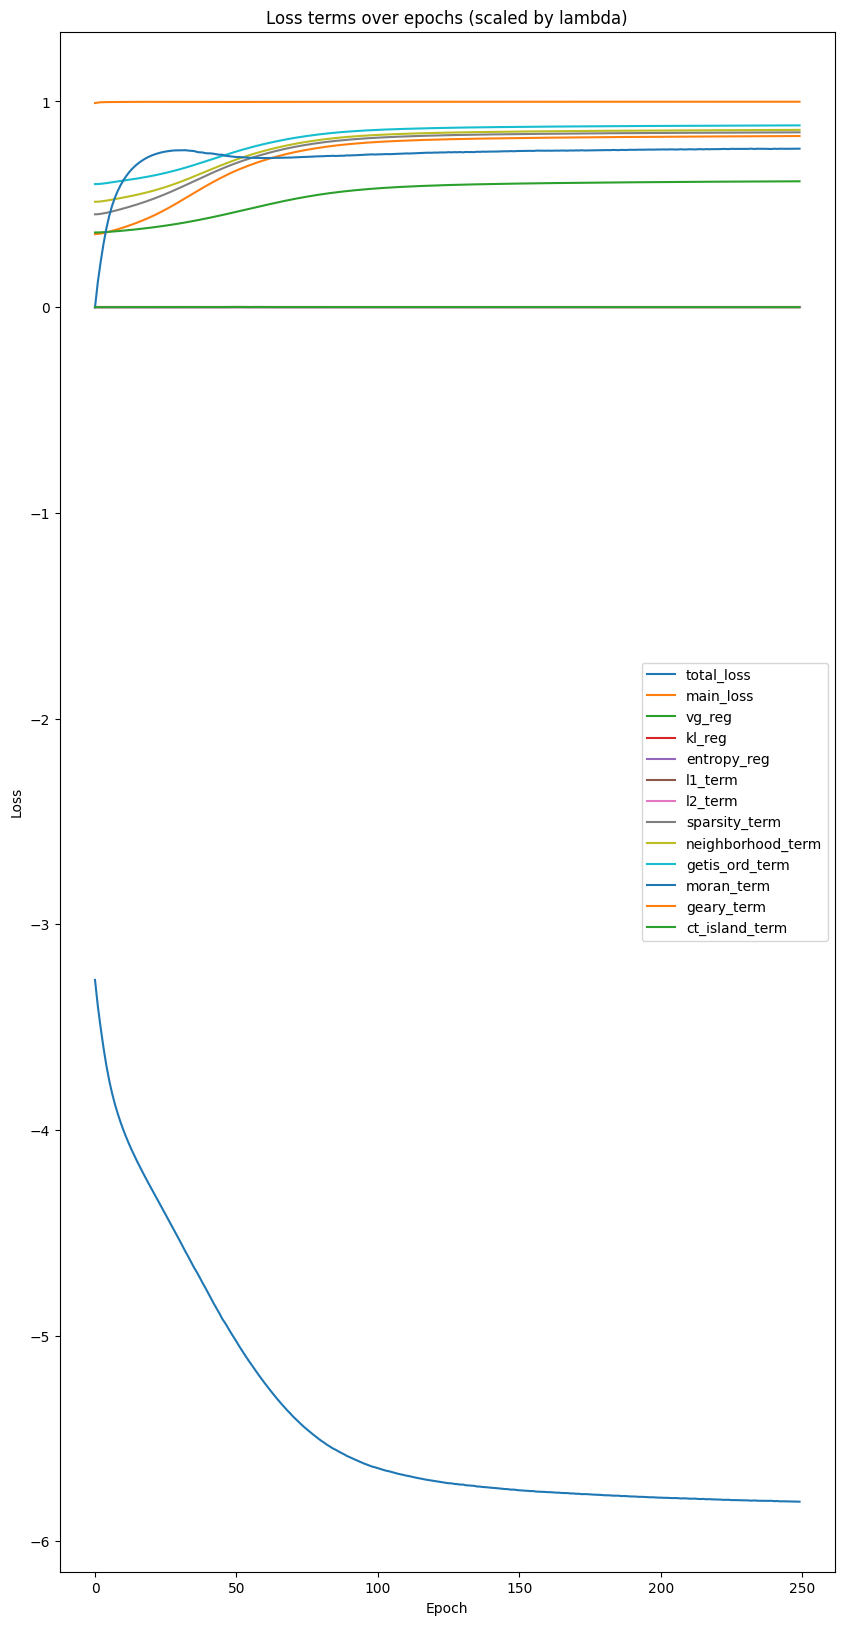

In [10]:
tgl.plot_training_history(adata_map=ad_map, hyperpams=mapper.hparams,
                   log_scale=False, lambda_scale=True)

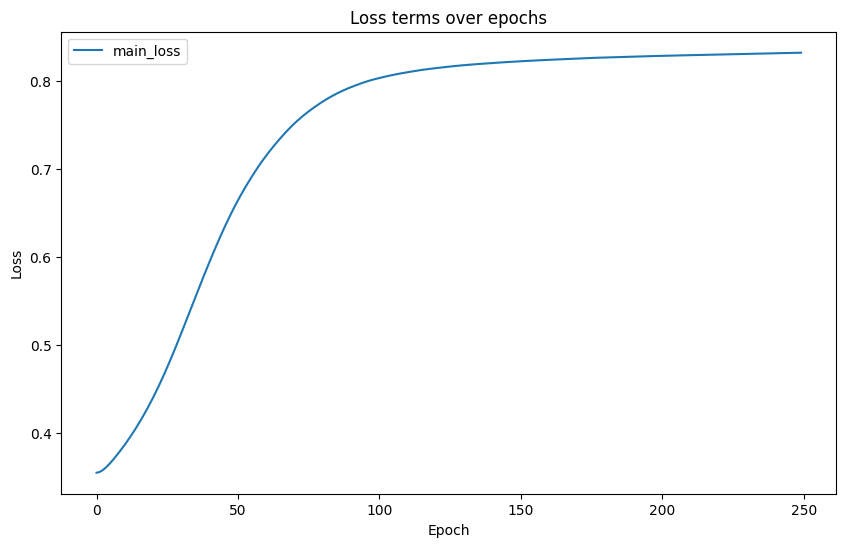

In [11]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map, loss_key="main_loss", lambda_scale=False)

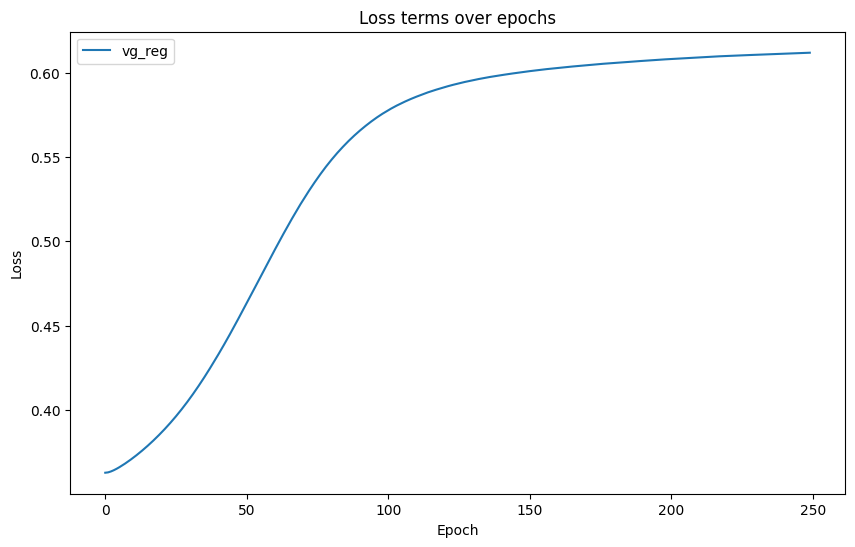

In [12]:
# Plot voxels/genes term
tgl.plot_loss_term(adata_map=ad_map, loss_key="vg_reg", lambda_scale=False)

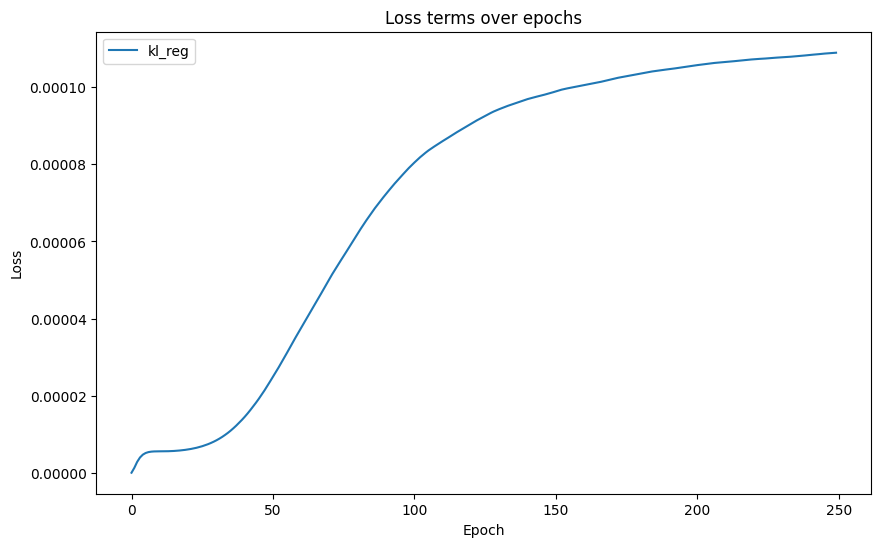

In [13]:
# Plot KL term
tgl.plot_loss_term(adata_map=ad_map, loss_key="kl_reg", lambda_scale=False)

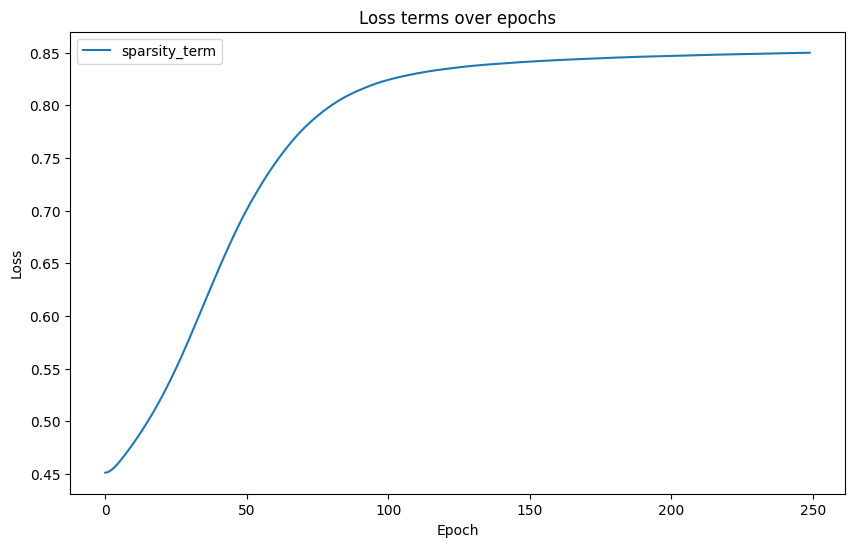

In [14]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="sparsity_term", lambda_scale=False)

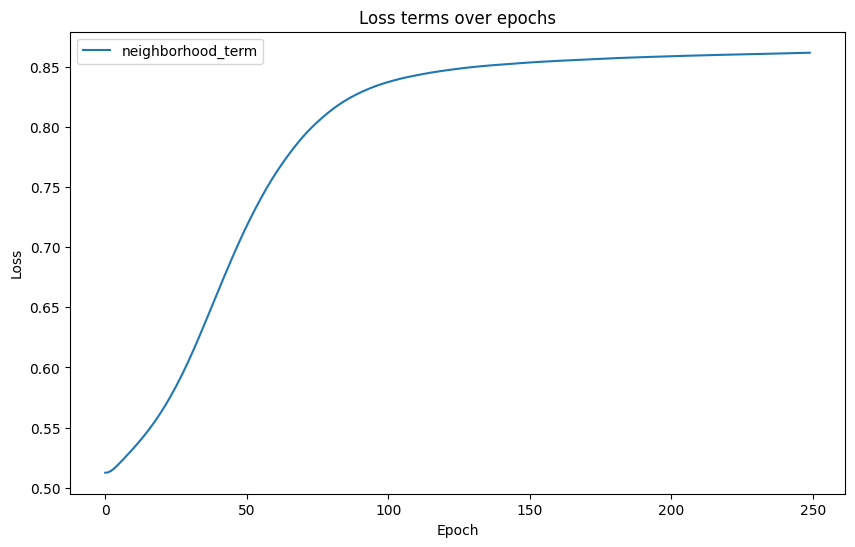

In [15]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="neighborhood_term", lambda_scale=False)

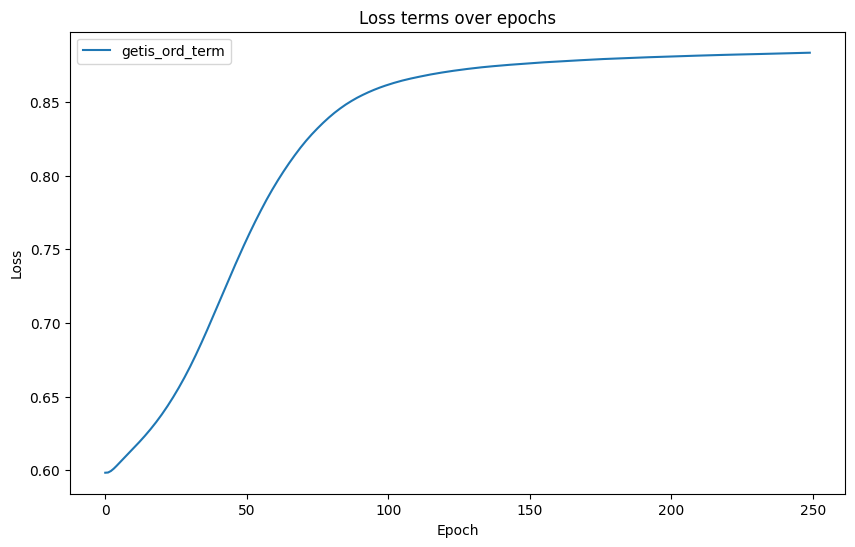

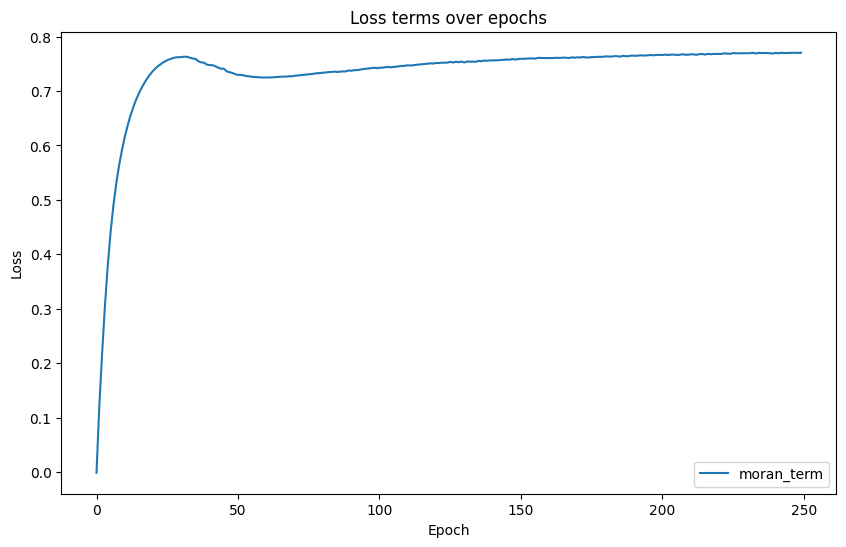

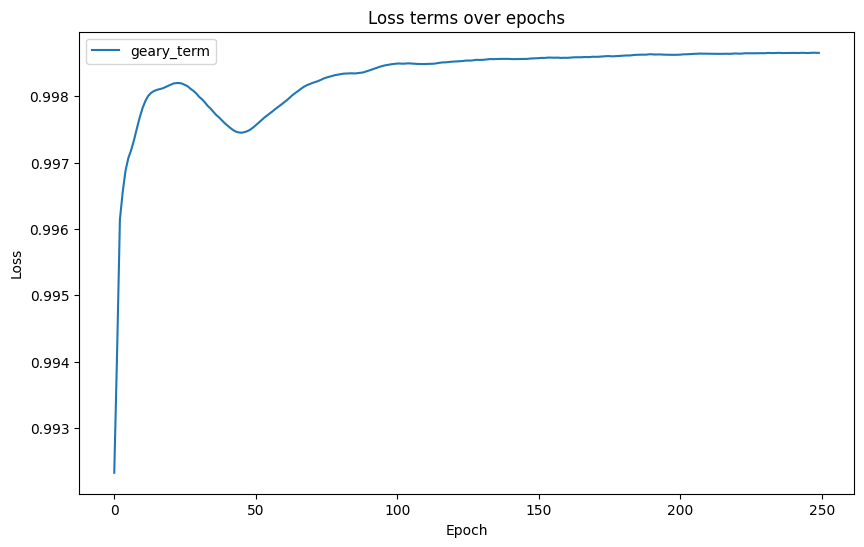

In [16]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="getis_ord_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map, loss_key="moran_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map, loss_key="geary_term", lambda_scale=False)

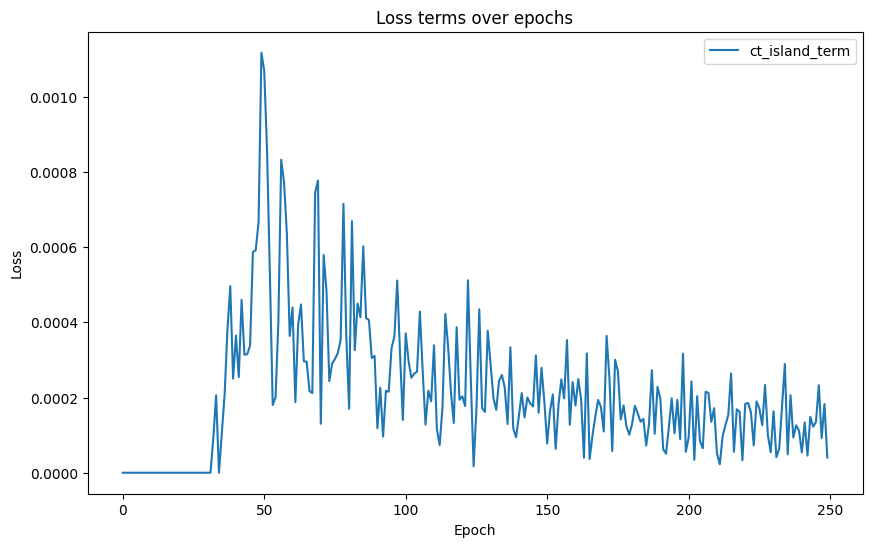

In [17]:
tgl.plot_loss_term(adata_map=ad_map, loss_key="ct_island_term", lambda_scale=False)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


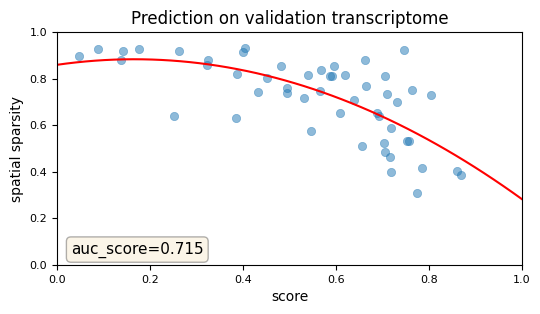

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.7150275111198425      │
│           val_JS            │     0.32442957162857056     │
│           val_PCC           │     0.47636204957962036     │
│          val_RMSE           │     1.0001044273376465      │
│          val_SSIM           │     0.29077187180519104     │
│         val_entropy         │     0.09383578598499298     │
│          val_score          │     0.5539061427116394      │
│ val_sparsity-weighted_score │    0.012447159737348557     │
└─────────────────────────────┴─────────────────────────────┘

In [18]:
full_val = tgl.validate_mapping_experiment(mapper, mapper_data)

## Sparsity Analysis

In [19]:
# Project all sc data onto spots
ad_ge = tgl.project_sc_genes_onto_space(ad_map, mapper_data)
ad_ge

AnnData object with n_obs × n_vars = 2133 × 31053
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'instance_id', 'centroid_x', 'centroid_y', 'region'
    var: 'gene_ids', 'feature_types', 'sparsity', 'is_training'
    uns: 'overlap_genes', 'training_genes'

In [20]:
# Create training genes scores dataframe
df = tgl.compare_spatial_gene_expr(ad_ge, mapper_data)

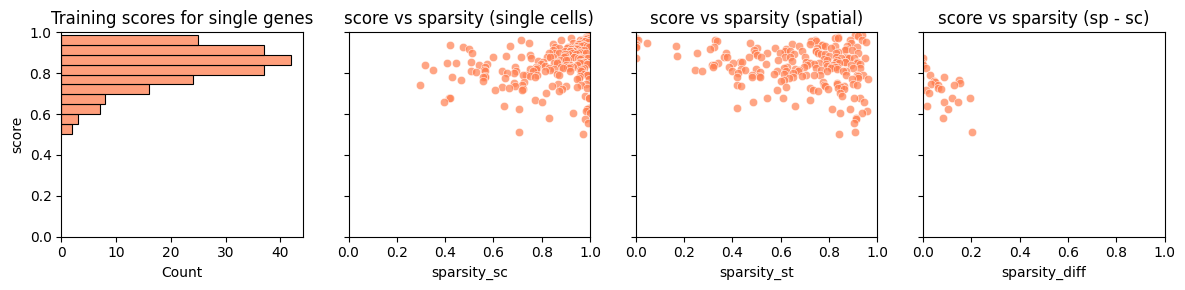

In [21]:
# Plot training scores panels
tgl.plot_training_scores(df)

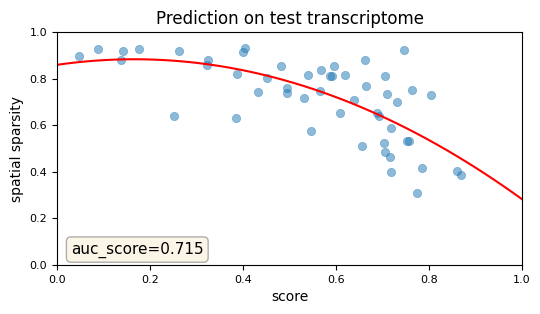

In [22]:
# Plot polyfit on test genes
tgl.plot_auc_curve(df)

## Save results

In [23]:
# Write tgl.map_cells_to_space() output to .h5ad
sc.write(filename='/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/results/adata_map_0', adata=ad_map, ext='h5ad')

## Reload model from ckpt

In [24]:
# Check state dict
mapper.state_dict().keys()

odict_keys(['M'])

In [25]:
# Load checkpoint
ckpt = torch.load("checkpoints/last.ckpt", map_location="cpu")  # last
ckpt['state_dict'].keys()


odict_keys(['M'])

In [30]:
ckpt['hyper_parameters']

{'filter': False,
 'learning_rate': 0.1,
 'num_epochs': 1000,
 'random_state': 42,
 'lambda_d': 0.001,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_r': 1e-09,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_count': 1,
 'lambda_f_reg': 1,
 'target_count': None,
 'lambda_sparsity_g1': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_getis_ord': 1,
 'lambda_geary': 1,
 'lambda_moran': 1,
 'lambda_ct_islands': 1}

In [ ]:
### does not work yet
from tangramlit import MapperLightning as ML

# Load into mapper
mapper_reload = ML.load_from_checkpoint("checkpoints/last.ckpt")
mapper_reload.state_dict()


RuntimeError: Error(s) in loading state_dict for MapperLightning:
	size mismatch for M: copying a param with shape torch.Size([80799, 2133]) from checkpoint, the shape in current model is torch.Size([0]).

# Filter

In [10]:
config_filt = config
config_filt['filter'] = True
config_filt['target_count'] = None
config_filt

{'cluster_label': 'Allen.class_label',
 'lambda_count': 0.001,
 'lambda_ct_islands': 1,
 'lambda_d': 0.001,
 'lambda_f_reg': 1e-05,
 'lambda_g1': 1,
 'lambda_g2': 1,
 'lambda_geary': 1,
 'lambda_getis_ord': 1,
 'lambda_l1': 1e-15,
 'lambda_l2': 1e-18,
 'lambda_moran': 1,
 'lambda_neighborhood_g1': 1,
 'lambda_r': 1e-09,
 'lambda_sparsity_g1': 1,
 'learning_rate': 0.1,
 'filter': True,
 'num_epochs': 1000,
 'random_state': 42,
 'target_count': None}

In [11]:
ad_map_filt, mapper_filt, mapper_data_filt = tgl.map_cells_to_space(
        adata_sc=adata_sc, 
        adata_st=adata_st, 
        train_genes_names=train_genes,
        val_genes_names=val_genes,
        **config_filt,
        )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name               | Type      | Params | Mode 
---------------------------------------------------------
0 | _density_criterion | KLDivLoss | 0      | train
  | other params       | n/a       | 172 M  | n/a  
---------------------------------------------------------
172 M     Trainable params
0         Non-trainable params
172 M     Total params
689.700   Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode



Validating with 50 genes
S matrix shape: torch.Size([80799, 50])
G matrix shape: torch.Size([2133, 50])

Validation 0: {'val_score': 0.371322363615036, 'val_sparsity-weighted_score': 0.009402037598192692, 'val_AUC': 0.4726836681365967, 'val_entropy': 0.9348850846290588}


Trainig:   0%|          | 0/1000 [00:00<?, ?it/s]


Training with 202 genes
S matrix shape: torch.Size([80799, 202])
G matrix shape: torch.Size([2133, 202])


Trainig:   0%|          | 1/1000 [00:26<7:23:18, 26.62s/it]

Epoch 0: {'loss': 35.075401306152344, 'main_loss': 0.3490564227104187, 'vg_reg': 0.36561304330825806, 'kl_reg': 1.3166806311915025e-08, 'entropy_reg': -0.0005790185532532632, 'l1_term': 1.375221785337999e-07, 'l2_term': 1.7236176375057255e-10, 'sparsity_term': 0.43832308053970337, 'neighborhood_term': 0.5085827708244324, 'getis_ord_term': 0.597042977809906, 'moran_term': -0.0003002693993039429, 'geary_term': 0.9917881488800049, 'ct_island_term': 0.0, 'count_reg': 38.15791702270508, 'lambda_f_reg': 0.16701018810272217}


Trainig:   5%|▍         | 49/1000 [21:11<6:50:33, 25.90s/it]Metric val_score improved. New best score: 0.510
Epoch 49, global step 50: 'val_score' reached 0.50954 (best 0.50954), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=49-val_score=0.510.ckpt' as top 3



Validation 49: {'val_score': 0.5095424056053162, 'val_sparsity-weighted_score': 0.011846516281366348, 'val_AUC': 0.593268632888794, 'val_entropy': 0.7938938736915588}


Trainig:  10%|▉         | 99/1000 [42:51<6:28:48, 25.89s/it]Metric val_score improved by 0.040 >= min_delta = 0.001. New best score: 0.550
Epoch 99, global step 100: 'val_score' reached 0.54981 (best 0.54981), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=99-val_score=0.550.ckpt' as top 3



Validation 99: {'val_score': 0.5498087406158447, 'val_sparsity-weighted_score': 0.01255380641669035, 'val_AUC': 0.6303485035896301, 'val_entropy': 0.6492408514022827}


Trainig:  10%|█         | 101/1000 [43:50<6:51:02, 27.43s/it]

Epoch 100: {'loss': -4.996372699737549, 'main_loss': 0.7266051769256592, 'vg_reg': 0.5100926160812378, 'kl_reg': 4.1026341932592914e-05, 'entropy_reg': -0.0004021055647172034, 'l1_term': 1.5658220320347027e-07, 'l2_term': 2.399491993987368e-10, 'sparsity_term': 0.7531153559684753, 'neighborhood_term': 0.7716751098632812, 'getis_ord_term': 0.8044584393501282, 'moran_term': 0.7200578451156616, 'geary_term': 0.9978839159011841, 'ct_island_term': 0.0, 'count_reg': 0.2687368392944336, 'lambda_f_reg': 0.018335433676838875, 'lr': 0.0010000000474974513, 'val_score': 0.5498087406158447, 'val_sparsity-weighted_score': 0.01255380641669035, 'val_AUC': 0.6303485035896301, 'val_entropy': 0.6492408514022827}


Trainig:  15%|█▍        | 149/1000 [1:04:30<6:07:10, 25.89s/it]Metric val_score improved by 0.001 >= min_delta = 0.001. New best score: 0.551
Epoch 149, global step 150: 'val_score' reached 0.55084 (best 0.55084), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=149-val_score=0.551.ckpt' as top 3



Validation 149: {'val_score': 0.5508356094360352, 'val_sparsity-weighted_score': 0.012571687810122967, 'val_AUC': 0.6313504576683044, 'val_entropy': 0.645213782787323}


Trainig:  20%|█▉        | 199/1000 [1:26:22<5:43:38, 25.74s/it]Monitored metric val_score did not improve in the last 1 records. Best score: 0.551. Signaling Trainer to stop.
Epoch 199, global step 200: 'val_score' reached 0.55180 (best 0.55180), saving model to '/nfsd/sysbiobig/bazzaccoen/tangramlit_dev/checkpoints/epoch=199-val_score=0.552.ckpt' as top 3



Validation 199: {'val_score': 0.5518011450767517, 'val_sparsity-weighted_score': 0.012588536366820335, 'val_AUC': 0.6322942972183228, 'val_entropy': 0.6411639451980591}


Trainig:  20%|██        | 200/1000 [1:26:55<5:47:40, 26.08s/it]


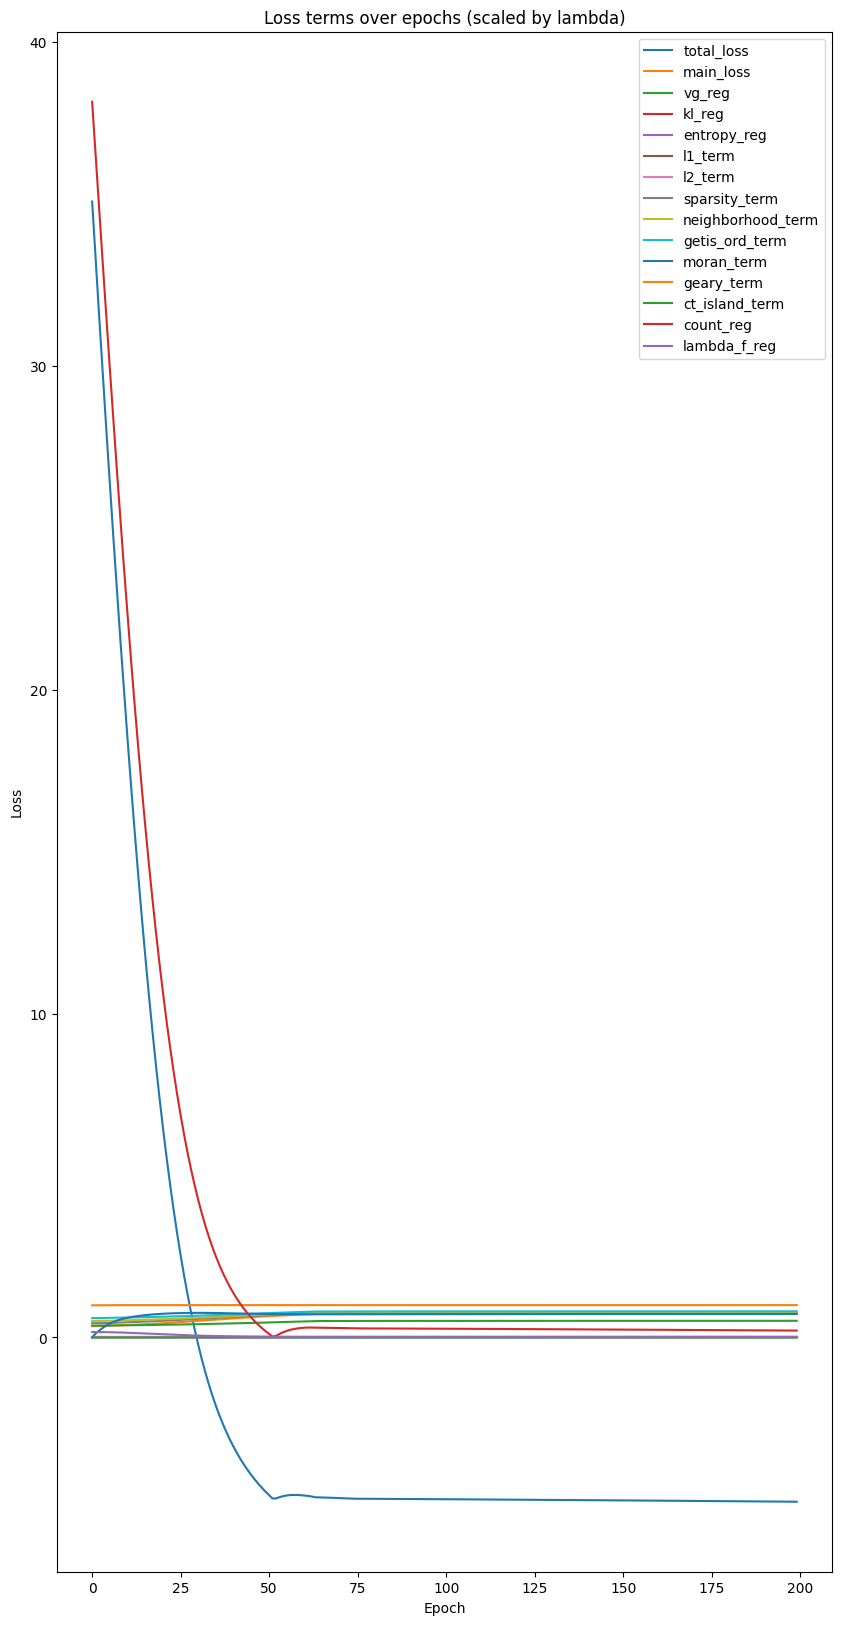

In [13]:
tgl.plot_training_history(adata_map=ad_map_filt, hyperpams=mapper_filt.hparams,
                   log_scale=False, lambda_scale=True)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


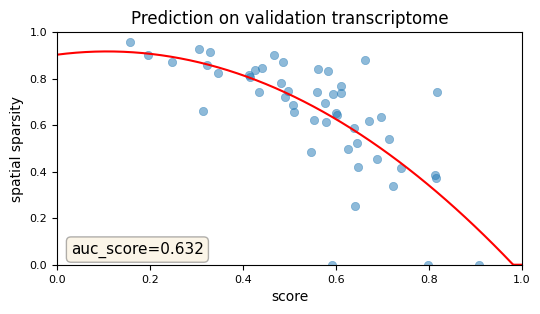

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric       ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           val_AUC           │     0.6322942972183228      │
│           val_JS            │     0.31632906198501587     │
│           val_PCC           │     0.47476083040237427     │
│          val_RMSE           │     1.0059441328048706      │
│          val_SSIM           │     0.24365393817424774     │
│         val_entropy         │     0.6411639451980591      │
│          val_score          │     0.5518011450767517      │
│ val_sparsity-weighted_score │    0.012588536366820335     │
└─────────────────────────────┴─────────────────────────────┘

In [15]:
full_val = tgl.validate_mapping_experiment(mapper_filt, mapper_data_filt)

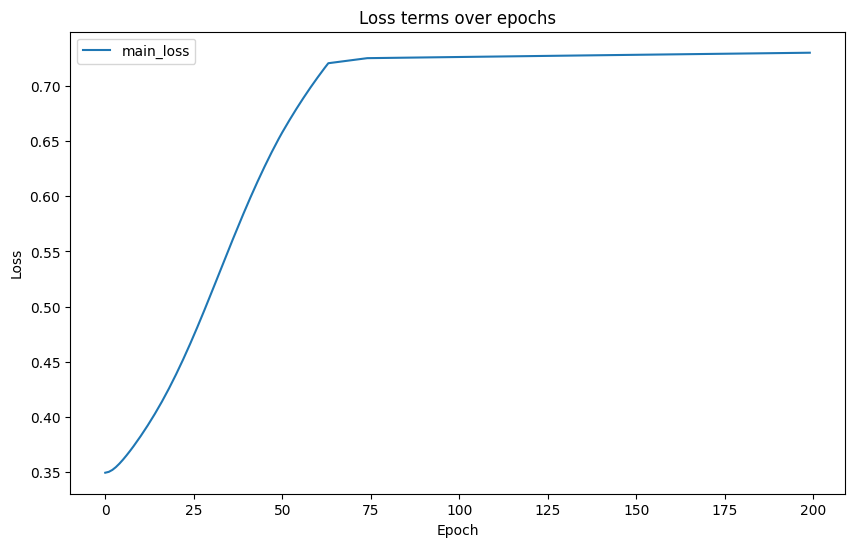

In [17]:
# Plot main loss
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="main_loss", lambda_scale=False)

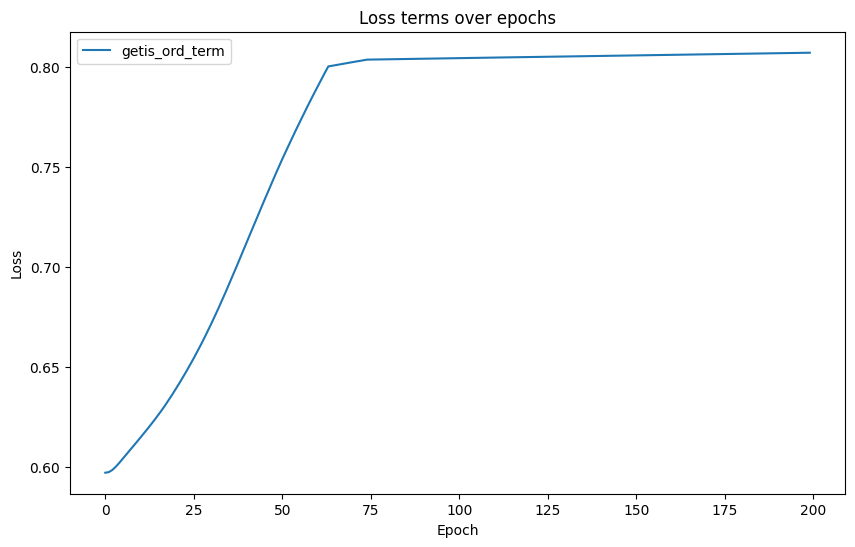

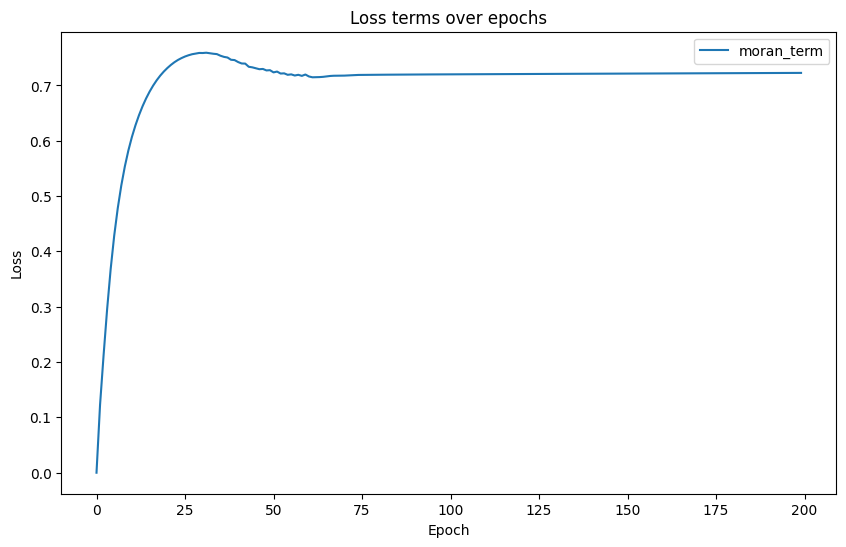

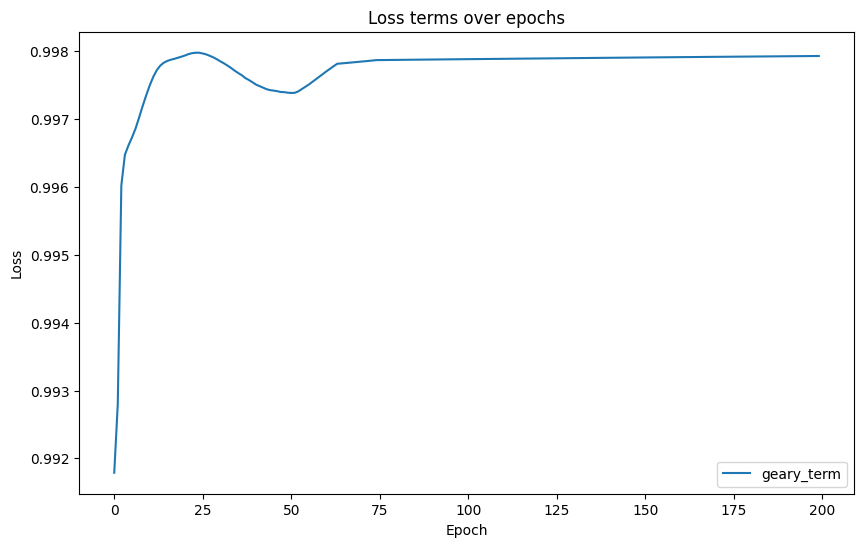

In [18]:
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="getis_ord_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="moran_term", lambda_scale=False)
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="geary_term", lambda_scale=False)

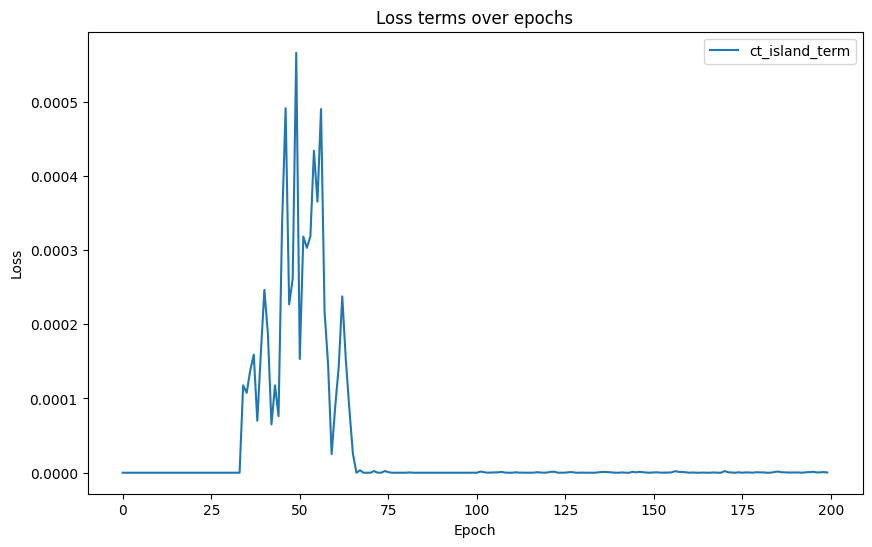

In [20]:
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="ct_island_term", lambda_scale=False)

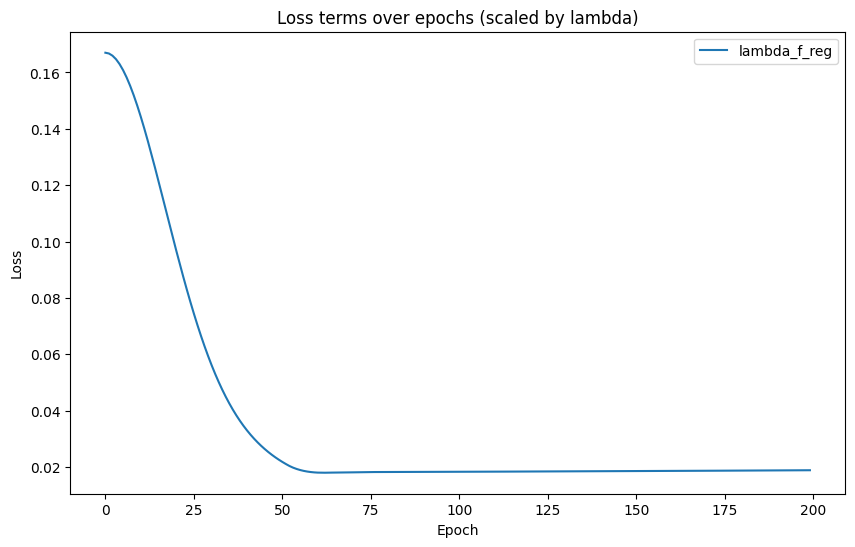

In [32]:
tgl.plot_loss_term(adata_map=ad_map_filt, loss_key="lambda_f_reg", lambda_coeff=mapper_filt.hparams.lambda_f_reg, lambda_scale=True)

In [30]:
mapper_filt.hparams.lambda_f_reg

1e-05

In [25]:
mapper_filt.hparams.target_count

2155

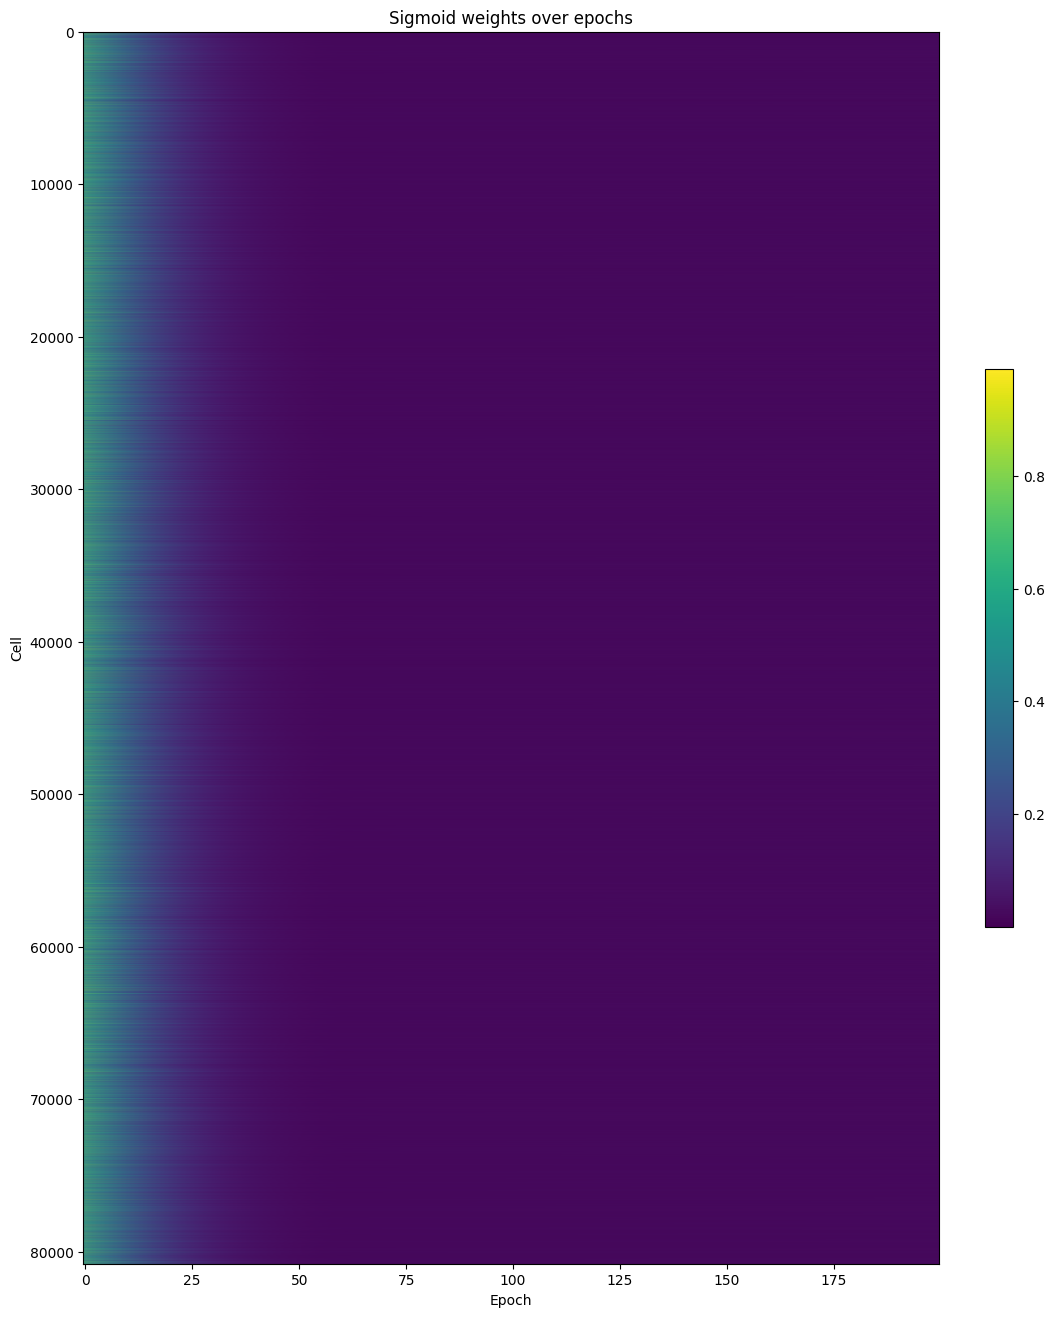

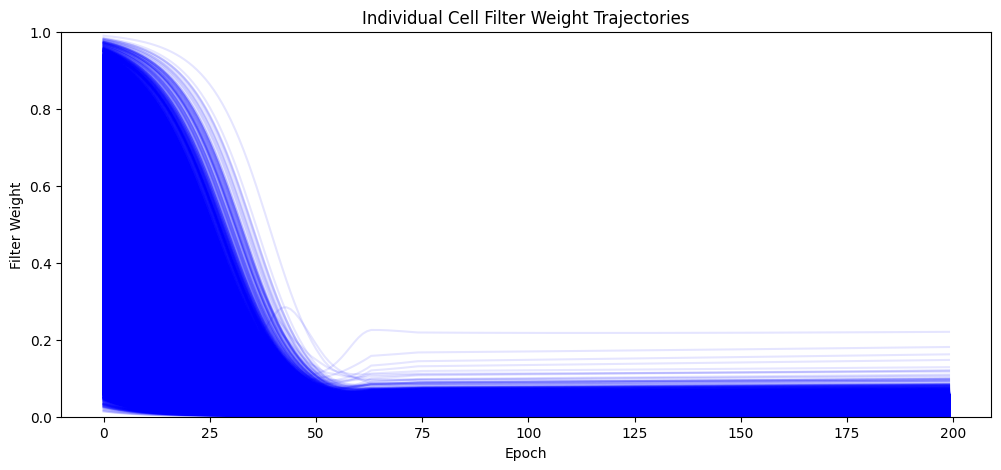

In [21]:
# Plot final filter values distribution
tgl.plot_filter_weights(ad_map_filt, plot_spaghetti=True, plot_envelope=False)

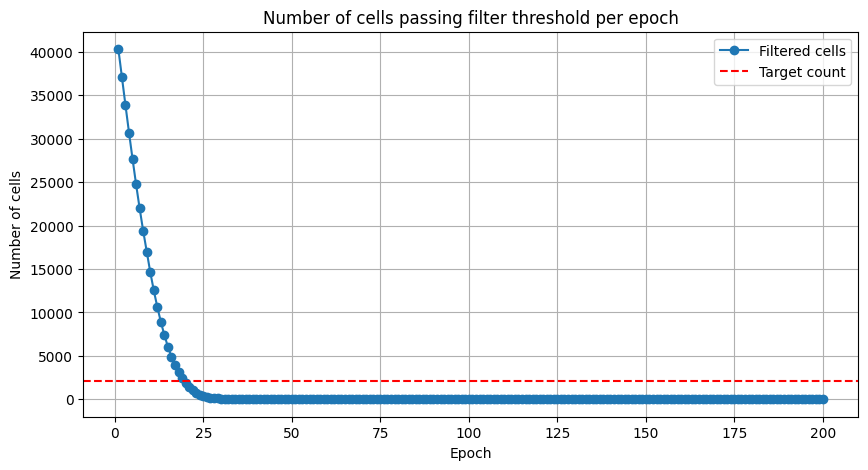

In [22]:
# Plot filter selection
tgl.plot_filter_count(ad_map_filt, target_count=None)

Pearson correlation coefficient of filter values: 0.9702063978242426


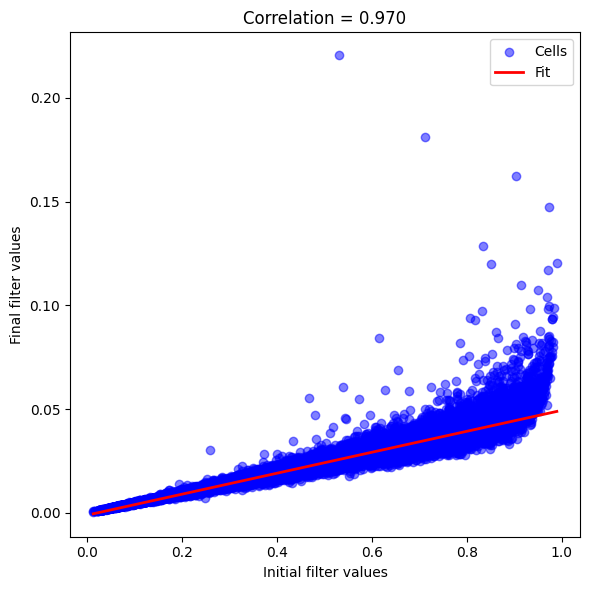

In [24]:
filt_corr = tgl.compute_filter_corr(ad_map_filt, plot_regression=True)